#  7.0 Model Analysis

## 7.0.0 Objective    
The objective of this notebook is to analyse the input data to the models to improve performance.This will ensure that data is of good quality and improve model performance. This approach is called **Data Centric approach** .


Source : https://www.deeplearning.ai/wp-content/uploads/2021/06/MLOps-From-Model-centric-to-Data-centric-AI.pdf   
Credit : Andrew Ng

In [1]:
import pandas as pd
import json
import seaborn as sns#Plots
import matplotlib.pylab as plt
import numpy as np
from scipy import stats
from datetime import datetime, timedelta

# Hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import lightgbm as lgb
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn import metrics 

In [2]:
#read pickle files
train1= pd.read_pickle('train1')
train2= pd.read_pickle('train2')
train3= pd.read_pickle('train3')
train4= pd.read_pickle('train4')
train5= pd.read_pickle('train5')

#concatenate all data
train_all = pd.concat([train1, train2, train3, train4, train5], axis=0, sort=False).reset_index(drop=True)

#totalTransactionRevenue_sum is same as revenue and can be dropped to avoid data leak
train_all= train_all.drop('totals.totalTransactionRevenue_sum',axis=1)

target_cols= ['returned','revenue','fullVisitorId']

train = train_all[train_all['revenue'].notnull()]
test  = train_all[train_all['revenue'].isnull()]

###  7.0.1 Create Classifier Data

In [3]:
#define target ,features for classifier
clf_target = train['returned']
clf_features = train.drop(target_cols,axis=1)

#check con=unts of target labels
print(clf_target.value_counts())

0.0    1347876
1.0       6976
Name: returned, dtype: int64


###  7.0.2 Create Regressor Data

In [4]:
#select data only fpr returned customers i.e returned =1 
reg_features = train.drop(target_cols,axis=1)[train['returned']==1]
#define target ,features for regressor
reg_target= train['revenue'][train['returned']==1]

###  7.0.3 Utility functions

In [5]:
# load test file
test_df= pd.read_csv("test_clean.csv",converters={"fullVisitorId": str},
                   usecols = ['fullVisitorId','totals.totalTransactionRevenue'] )

test_df['totals.totalTransactionRevenue'].fillna(0, inplace=True)           

def regr_metric(test_df,submit_df):
    ''' 
    Calculate & print regresion metrics
    '''
    test_grp= test_df.groupby('fullVisitorId')\
           ['totals.totalTransactionRevenue'].sum().apply(np.log1p,ais=1).reset_index()
    test_grp = pd.merge(test_grp,submit_df,on='fullVisitorId')
    rms= np.sqrt(metrics.mean_squared_error(test_grp['totals.totalTransactionRevenue'],
                                        test_grp['PredictedLogRevenue']))
    map = metrics.mean_absolute_error(test_grp['totals.totalTransactionRevenue'],test_grp['PredictedLogRevenue'])
    print('rms =',rms)
    print('map =',map)

def sub_file(y_true,y_pred):
    ''' 
    Submit file for kaggle
    '''
    submit_df=pd.DataFrame()
    submit_df['fullVisitorId']=y_true['fullVisitorId']
    submit_df['PredictedLogRevenue'] = y_pred
    return submit_df

##  7.1 LightGBM  

Light GBM grows tree vertically while other algorithm grows trees horizontally meaning that Light GBM grows tree leaf-wise while other algorithm grows level-wise. It will choose the leaf with max delta loss to grow. When growing the same leaf, Leaf-wise algorithm can reduce more loss than a level-wise algorithm.

## 7.1.1 LBG classification model :

In [6]:
clf = lgb.LGBMClassifier()
#check default parameters
clf.get_params() 

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': 'warn',
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

In [7]:
gridParams = {
'learning_rate': [0.01,0.02,0.04,0.06,0.08,0.1], #Learning rate
'n_estimators': [int(x) for x in np.linspace(start = 100, stop = 2000, num = 15)],
'num_leaves': [1,3,5,7,9,11,13,15,17], #number of leaves in full tree
'boosting_type' : ['gbdt'],
'objective' : ['binary'], #Binary Classification model  
'metric' : ['binary_logloss'], #Performance metric 
'colsample_bytree' : [ 0.2,0.4,0.6,0.7,0.8, 1], #  select % of features before training each tree
'subsample' : [0.2,0.4,0.6,0.7,0.8,0.9], # select part of data without resampling
'reg_alpha' : [0,0.25,0.5,0.75,1], #L1 regularization
'reg_lambda' : [0,0.25,0.5,0.75,1], #L2 regularization
'max_leaves': [32,64,128,256], #Max  nodes  added.
'min_child_samples' : [1,2,3,4,5,7,8,9,10] #Min data points in child (leaf) node.
}

In [8]:
lbg_clf_grid = RandomizedSearchCV(estimator=clf, param_distributions=gridParams,
                              n_iter =25, 
                              cv = 2, verbose=10, random_state=42,  
                              return_train_score=True)

In [9]:
%%time 
lbg_clf_grid.fit(clf_features, clf_target)

Fitting 2 folds for each of 25 candidates, totalling 50 fits
[CV 1/2; 1/25] START boosting_type=gbdt, colsample_bytree=1, learning_rate=0.02, max_leaves=256, metric=binary_logloss, min_child_samples=3, n_estimators=1457, num_leaves=11, objective=binary, reg_alpha=0.75, reg_lambda=0.5, subsample=0.6
[LightGBM] [Warning] num_leaves is set=11, max_leaves=256 will be ignored. Current value: num_leaves=11
[CV 1/2; 1/25] END boosting_type=gbdt, colsample_bytree=1, learning_rate=0.02, max_leaves=256, metric=binary_logloss, min_child_samples=3, n_estimators=1457, num_leaves=11, objective=binary, reg_alpha=0.75, reg_lambda=0.5, subsample=0.6;, score=(train=0.996, test=0.384) total time= 3.2min
[CV 2/2; 1/25] START boosting_type=gbdt, colsample_bytree=1, learning_rate=0.02, max_leaves=256, metric=binary_logloss, min_child_samples=3, n_estimators=1457, num_leaves=11, objective=binary, reg_alpha=0.75, reg_lambda=0.5, subsample=0.6
[LightGBM] [Warning] num_leaves is set=11, max_leaves=256 will be i

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .



[LightGBM] [Warning] num_leaves is set=1, max_leaves=64 will be ignored. Current value: num_leaves=1
[CV 2/2; 5/25] END boosting_type=gbdt, colsample_bytree=0.7, learning_rate=0.01, max_leaves=64, metric=binary_logloss, min_child_samples=1, n_estimators=1185, num_leaves=1, objective=binary, reg_alpha=0.25, reg_lambda=0.5, subsample=0.2;, score=(train=nan, test=nan) total time=   6.8s
[CV 1/2; 6/25] START boosting_type=gbdt, colsample_bytree=0.2, learning_rate=0.06, max_leaves=32, metric=binary_logloss, min_child_samples=3, n_estimators=778, num_leaves=3, objective=binary, reg_alpha=0.5, reg_lambda=1, subsample=0.9


[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .



[LightGBM] [Warning] num_leaves is set=3, max_leaves=32 will be ignored. Current value: num_leaves=3
[CV 1/2; 6/25] END boosting_type=gbdt, colsample_bytree=0.2, learning_rate=0.06, max_leaves=32, metric=binary_logloss, min_child_samples=3, n_estimators=778, num_leaves=3, objective=binary, reg_alpha=0.5, reg_lambda=1, subsample=0.9;, score=(train=0.995, test=0.397) total time=  54.9s
[CV 2/2; 6/25] START boosting_type=gbdt, colsample_bytree=0.2, learning_rate=0.06, max_leaves=32, metric=binary_logloss, min_child_samples=3, n_estimators=778, num_leaves=3, objective=binary, reg_alpha=0.5, reg_lambda=1, subsample=0.9
[LightGBM] [Warning] num_leaves is set=3, max_leaves=32 will be ignored. Current value: num_leaves=3
[CV 2/2; 6/25] END boosting_type=gbdt, colsample_bytree=0.2, learning_rate=0.06, max_leaves=32, metric=binary_logloss, min_child_samples=3, n_estimators=778, num_leaves=3, objective=binary, reg_alpha=0.5, reg_lambda=1, subsample=0.9;, score=(train=0.995, test=0.995) total time

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .



[LightGBM] [Warning] num_leaves is set=1, max_leaves=256 will be ignored. Current value: num_leaves=1
[CV 2/2; 8/25] END boosting_type=gbdt, colsample_bytree=1, learning_rate=0.04, max_leaves=256, metric=binary_logloss, min_child_samples=7, n_estimators=642, num_leaves=1, objective=binary, reg_alpha=0, reg_lambda=1, subsample=0.8;, score=(train=nan, test=nan) total time=   6.9s
[CV 1/2; 9/25] START boosting_type=gbdt, colsample_bytree=0.6, learning_rate=0.02, max_leaves=32, metric=binary_logloss, min_child_samples=9, n_estimators=1050, num_leaves=5, objective=binary, reg_alpha=0, reg_lambda=0.75, subsample=0.4


[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .



[LightGBM] [Warning] num_leaves is set=5, max_leaves=32 will be ignored. Current value: num_leaves=5
[CV 1/2; 9/25] END boosting_type=gbdt, colsample_bytree=0.6, learning_rate=0.02, max_leaves=32, metric=binary_logloss, min_child_samples=9, n_estimators=1050, num_leaves=5, objective=binary, reg_alpha=0, reg_lambda=0.75, subsample=0.4;, score=(train=0.995, test=0.530) total time= 2.5min
[CV 2/2; 9/25] START boosting_type=gbdt, colsample_bytree=0.6, learning_rate=0.02, max_leaves=32, metric=binary_logloss, min_child_samples=9, n_estimators=1050, num_leaves=5, objective=binary, reg_alpha=0, reg_lambda=0.75, subsample=0.4
[LightGBM] [Warning] num_leaves is set=5, max_leaves=32 will be ignored. Current value: num_leaves=5
[CV 2/2; 9/25] END boosting_type=gbdt, colsample_bytree=0.6, learning_rate=0.02, max_leaves=32, metric=binary_logloss, min_child_samples=9, n_estimators=1050, num_leaves=5, objective=binary, reg_alpha=0, reg_lambda=0.75, subsample=0.4;, score=(train=0.995, test=0.995) tota

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .



[LightGBM] [Warning] num_leaves is set=1, max_leaves=32 will be ignored. Current value: num_leaves=1
[CV 2/2; 13/25] END boosting_type=gbdt, colsample_bytree=0.4, learning_rate=0.08, max_leaves=32, metric=binary_logloss, min_child_samples=7, n_estimators=1457, num_leaves=1, objective=binary, reg_alpha=0.75, reg_lambda=0.5, subsample=0.2;, score=(train=nan, test=nan) total time=   6.8s
[CV 1/2; 14/25] START boosting_type=gbdt, colsample_bytree=0.4, learning_rate=0.01, max_leaves=256, metric=binary_logloss, min_child_samples=4, n_estimators=100, num_leaves=1, objective=binary, reg_alpha=0, reg_lambda=0, subsample=0.9


[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .



[LightGBM] [Warning] num_leaves is set=1, max_leaves=256 will be ignored. Current value: num_leaves=1
[CV 1/2; 14/25] END boosting_type=gbdt, colsample_bytree=0.4, learning_rate=0.01, max_leaves=256, metric=binary_logloss, min_child_samples=4, n_estimators=100, num_leaves=1, objective=binary, reg_alpha=0, reg_lambda=0, subsample=0.9;, score=(train=nan, test=nan) total time=   6.8s
[CV 2/2; 14/25] START boosting_type=gbdt, colsample_bytree=0.4, learning_rate=0.01, max_leaves=256, metric=binary_logloss, min_child_samples=4, n_estimators=100, num_leaves=1, objective=binary, reg_alpha=0, reg_lambda=0, subsample=0.9


[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .



[LightGBM] [Warning] num_leaves is set=1, max_leaves=256 will be ignored. Current value: num_leaves=1
[CV 2/2; 14/25] END boosting_type=gbdt, colsample_bytree=0.4, learning_rate=0.01, max_leaves=256, metric=binary_logloss, min_child_samples=4, n_estimators=100, num_leaves=1, objective=binary, reg_alpha=0, reg_lambda=0, subsample=0.9;, score=(train=nan, test=nan) total time=   6.9s
[CV 1/2; 15/25] START boosting_type=gbdt, colsample_bytree=0.7, learning_rate=0.02, max_leaves=32, metric=binary_logloss, min_child_samples=7, n_estimators=100, num_leaves=15, objective=binary, reg_alpha=0.5, reg_lambda=0.25, subsample=0.4


[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .



[LightGBM] [Warning] num_leaves is set=15, max_leaves=32 will be ignored. Current value: num_leaves=15
[CV 1/2; 15/25] END boosting_type=gbdt, colsample_bytree=0.7, learning_rate=0.02, max_leaves=32, metric=binary_logloss, min_child_samples=7, n_estimators=100, num_leaves=15, objective=binary, reg_alpha=0.5, reg_lambda=0.25, subsample=0.4;, score=(train=0.995, test=0.521) total time=  32.6s
[CV 2/2; 15/25] START boosting_type=gbdt, colsample_bytree=0.7, learning_rate=0.02, max_leaves=32, metric=binary_logloss, min_child_samples=7, n_estimators=100, num_leaves=15, objective=binary, reg_alpha=0.5, reg_lambda=0.25, subsample=0.4
[LightGBM] [Warning] num_leaves is set=15, max_leaves=32 will be ignored. Current value: num_leaves=15
[CV 2/2; 15/25] END boosting_type=gbdt, colsample_bytree=0.7, learning_rate=0.02, max_leaves=32, metric=binary_logloss, min_child_samples=7, n_estimators=100, num_leaves=15, objective=binary, reg_alpha=0.5, reg_lambda=0.25, subsample=0.4;, score=(train=0.995, tes

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
8 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
8 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py", line 972, in fit
    callbacks=callbacks, init_model=init_model)
  File "/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py", line 758, in fit
    callbacks=callbacks
  File "/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py", line 271

[LightGBM] [Warning] num_leaves is set=3, max_leaves=32 will be ignored. Current value: num_leaves=3
CPU times: user 5h 34min 46s, sys: 4min 10s, total: 5h 38min 57s
Wall time: 1h 36min 41s


RandomizedSearchCV(cv=2, estimator=LGBMClassifier(), n_iter=25,
                   param_distributions={'boosting_type': ['gbdt'],
                                        'colsample_bytree': [0.2, 0.4, 0.6, 0.7,
                                                             0.8, 1],
                                        'learning_rate': [0.01, 0.02, 0.04,
                                                          0.06, 0.08, 0.1],
                                        'max_leaves': [32, 64, 128, 256],
                                        'metric': ['binary_logloss'],
                                        'min_child_samples': [1, 2, 3, 4, 5, 7,
                                                              8, 9, 10],
                                        'n_estimators': [100, 235, 371, 507,
                                                         642, 778, 914, 1050,
                                                         1185, 1321, 1457, 1592,
                                 

In [10]:
lbg_clf_grid.best_params_

{'subsample': 0.4,
 'reg_lambda': 0.5,
 'reg_alpha': 0.5,
 'objective': 'binary',
 'num_leaves': 3,
 'n_estimators': 642,
 'min_child_samples': 9,
 'metric': 'binary_logloss',
 'max_leaves': 32,
 'learning_rate': 0.01,
 'colsample_bytree': 0.4,
 'boosting_type': 'gbdt'}

In [11]:
lbg_clf_grid.best_score_

0.8128946925568254

In [12]:
lbg_clfparm = {
"objective" : "binary", #Binary Classification model to predict whether customer will return during test window
"metric" : "binary_logloss", #Performance metric as "Binary Logloss"
"max_leaves": 32, #Maximum number of nodes to be added.
"num_leaves" : 3, #number of leaves in full tree
"min_child_samples" : 9, #Minimum number of data points needed in a child (leaf) node.
"learning_rate" : 0.01, #Learning rate
"subsample" : 0.4, #this will randomly select part of data without resampling
"colsample_bytree" : 0.4, #LightGBM will select 80% of features before training each tree
"bagging_frequency" : 1, #Perform bagging at every k iteration
"n_estimators" : 642, #number of boosting iterations
"reg_alpha" : 0.5, #L1 regularization
"reg_lambda": 0.5, #L2 regularization
"boosting_type" : "gbdt"}

lbgclf = lgb.LGBMClassifier(**lbg_clfparm)
#lgbm_clf.set_params(**lbg_clfparm)                        
lbgclf.get_params() 

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 0.4,
 'importance_type': 'split',
 'learning_rate': 0.01,
 'max_depth': -1,
 'min_child_samples': 9,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 642,
 'n_jobs': -1,
 'num_leaves': 3,
 'objective': 'binary',
 'random_state': None,
 'reg_alpha': 0.5,
 'reg_lambda': 0.5,
 'silent': 'warn',
 'subsample': 0.4,
 'subsample_for_bin': 200000,
 'subsample_freq': 0,
 'metric': 'binary_logloss',
 'max_leaves': 32,
 'bagging_frequency': 1}

In [13]:
%%time
lbgclf.fit(clf_features, clf_target)

CPU times: user 6min 53s, sys: 3.37 s, total: 6min 56s
Wall time: 1min 54s


LGBMClassifier(bagging_frequency=1, colsample_bytree=0.4, learning_rate=0.01,
               max_leaves=32, metric='binary_logloss', min_child_samples=9,
               n_estimators=642, num_leaves=3, objective='binary',
               reg_alpha=0.5, reg_lambda=0.5, subsample=0.4)

In [14]:
pred_prob = lbgclf.predict_proba(clf_features)

In [15]:
y_pred_lbg1  =  lbgclf.predict(clf_features)

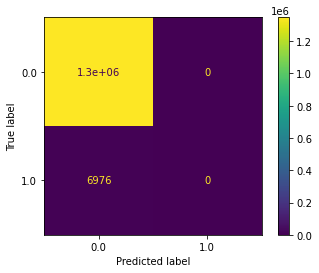

In [16]:
ConfusionMatrixDisplay.from_predictions(clf_target, y_pred_lbg1)

### 7.1.2 LBG classifier feature Analysis :

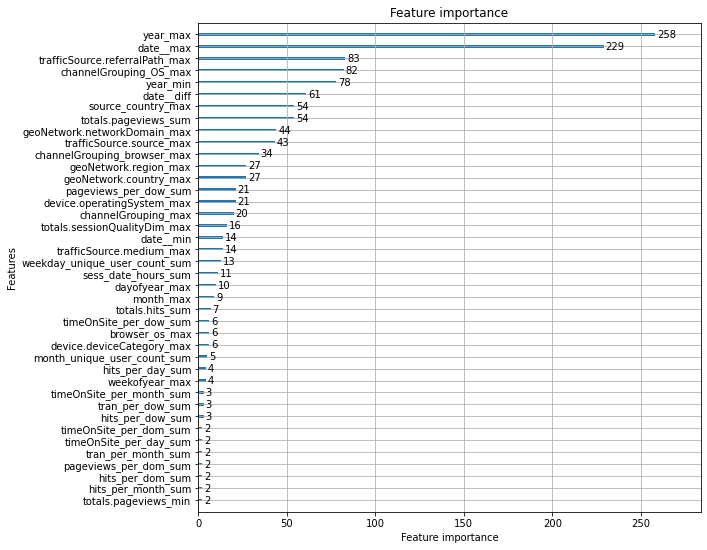

In [17]:
ax=lgb.plot_importance(lbgclf)
ax.figure.set_size_inches(9,9)

 The Classifier Feature importance shows, temporal features like year_max, date_max are important for classifier. 
     

In [18]:
#save classifier features in csv file
feature_lst =  list(clf_features.columns)

results=pd.DataFrame()
results['columns']=feature_lst
results['importances'] = lbgclf.feature_importances_
results.sort_values(by='importances',ascending=False,inplace=True)

In [19]:
results.to_csv('clf_fi.csv',index=False)

### 7.1.3 LBG classifier Data  Analysis :

Here we analyse input data to classifier using graph and data queries

In [20]:
#combine features and labels
clf1_data = pd.concat([clf_features, clf_target], axis = 1)

<AxesSubplot:xlabel='returned', ylabel='year_max'>

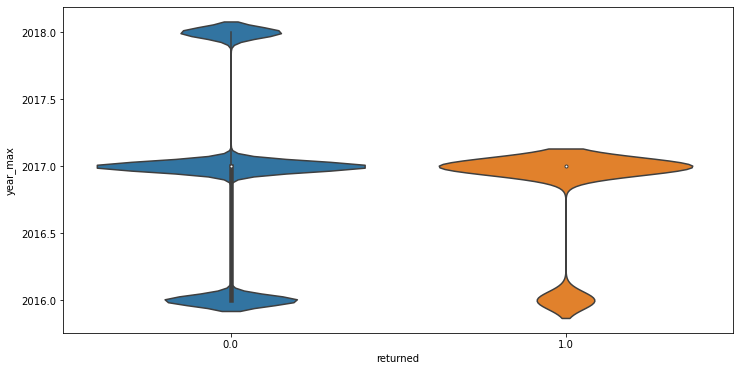

In [21]:
fig=plt.gcf()
fig.set_size_inches(12,6)
sns.violinplot(x='returned',y='year_max',data=clf1_data) 

<AxesSubplot:xlabel='returned', ylabel='date__max'>

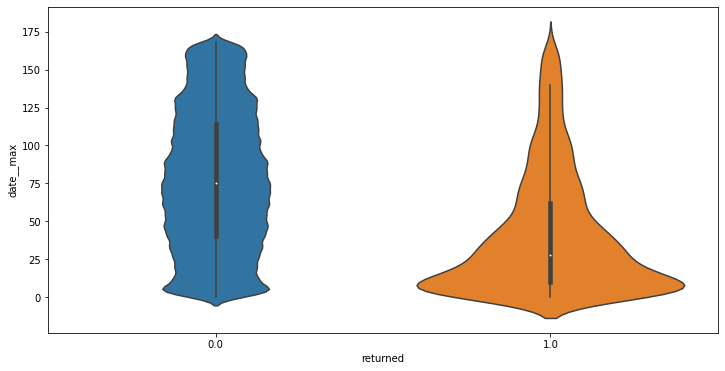

In [22]:
fig=plt.gcf()
fig.set_size_inches(12,6)
sns.violinplot(x='returned',y='date__max',data=clf1_data) 

<AxesSubplot:xlabel='returned', ylabel='trafficSource.referralPath_max'>

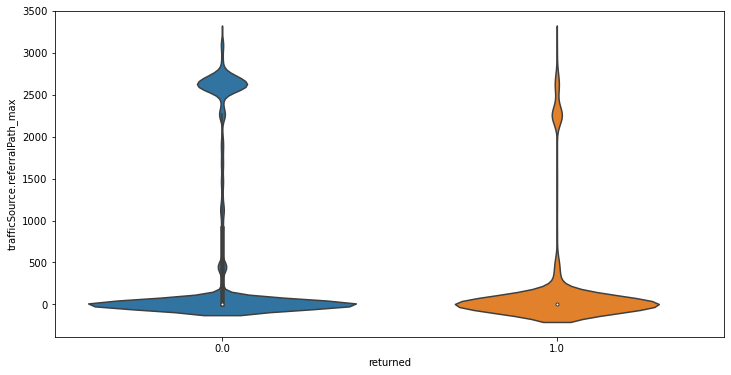

In [23]:
fig=plt.gcf()
fig.set_size_inches(12,6)
sns.violinplot(x='returned',y='trafficSource.referralPath_max',data=clf1_data) 

<AxesSubplot:xlabel='returned', ylabel='channelGrouping_OS_max'>

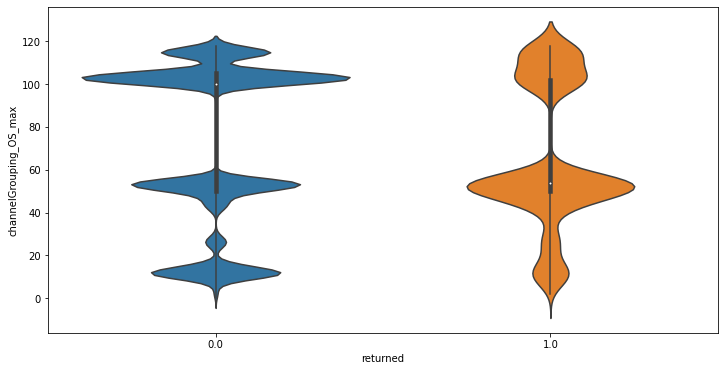

In [24]:
fig=plt.gcf()
fig.set_size_inches(12,6)
sns.violinplot(x='returned',y='channelGrouping_OS_max',data=clf1_data) 

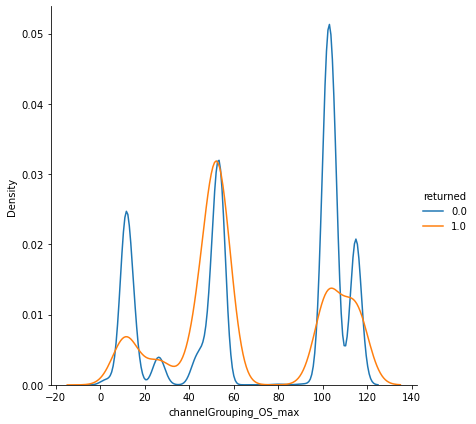

In [25]:
#https://www.kaggle.com/biphili/seaborn-matplotlib-iris-data-visualization-code-1
sns.FacetGrid(clf1_data, hue="returned", height=6) \
   .map(sns.kdeplot, "channelGrouping_OS_max") \
   .add_legend()
plt.ioff()

<AxesSubplot:xlabel='returned', ylabel='date__diff'>

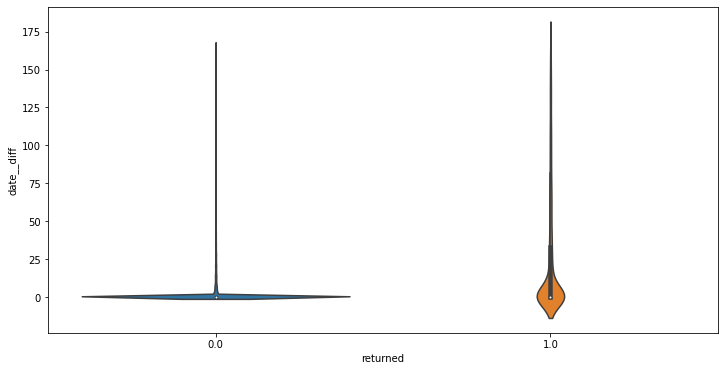

In [26]:
fig=plt.gcf()
fig.set_size_inches(12,6)
sns.violinplot(x='returned',y='date__diff',data=clf1_data) 

<AxesSubplot:xlabel='returned', ylabel='year_min'>

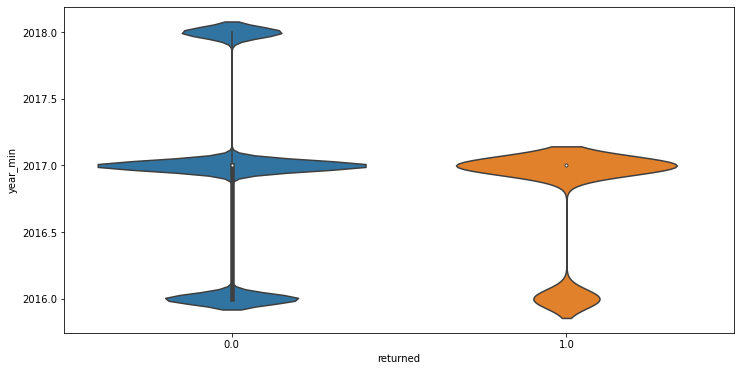

In [27]:
fig=plt.gcf()
fig.set_size_inches(12,6)
sns.violinplot(x='returned',y='year_min',data=clf1_data) 

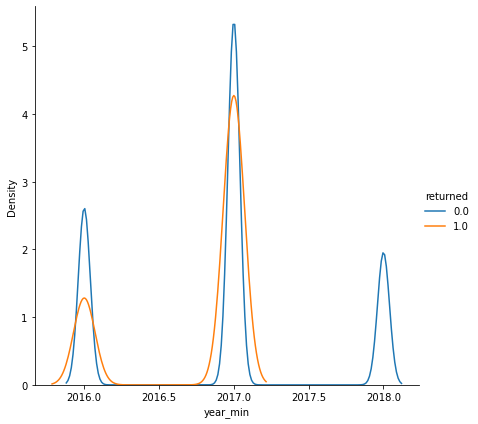

In [28]:
sns.FacetGrid(clf1_data, hue="returned", height=6) \
   .map(sns.kdeplot, "year_min") \
   .add_legend()
plt.ioff()

In [29]:
 clf1_data.groupby(['returned', 'year_max']).size()

returned  year_max
0.0       2016.0      352030
          2017.0      728376
          2018.0      267470
1.0       2016.0        1292
          2017.0        5684
dtype: int64

In [134]:
pd.set_option("display.max_rows", None)
clf1_data.groupby(['returned', 'geoNetwork.networkDomain_max']).size()

returned  geoNetwork.networkDomain_max
0.0       0                               340587
          1                                    3
          2                                  340
          3                                  143
          4                                    1
          5                                  856
          7                                    1
          8                                   40
          9                                    1
          10                                   1
          11                                   9
          12                                   1
          13                                   1
          14                                   3
          15                                   1
          16                                   3
          17                                  24
          18                                   1
          19                                  48
          20                  

In [135]:
clf1_data[clf1_data['trafficSource.referralPath_max'].isin([0,1])  ]['returned'].value_counts()

0.0    962643
1.0      6108
Name: returned, dtype: int64

In [136]:
clf1_data[clf1_data['channelGrouping_OS_max'].isin([46,50,54,102,115])  ]['returned'].value_counts()

0.0    461930
1.0      3613
Name: returned, dtype: int64

In [137]:
clf1_data[clf1_data['year_max'] == 2017]['returned'].value_counts()

0.0    728376
1.0      5684
Name: returned, dtype: int64

In [138]:
clf1_data[clf1_data['geoNetwork.networkDomain_max'].isin([0,7652,39450,38725,31119])  ]['returned'].value_counts()

0.0    659601
1.0      4527
Name: returned, dtype: int64

In [139]:
clf1_data[clf1_data['trafficSource.source_max'].isin([0,99])]['returned'].value_counts()

0.0    921864
1.0      6213
Name: returned, dtype: int64

In [140]:
clf1_data[clf1_data['channelGrouping_browser_max'].isin([64,66,68])]['returned'].value_counts()

0.0    656566
1.0      4832
Name: returned, dtype: int64

In [13]:
'''
clf1_data['y_pred']= y_pred_lbg1
clf1_data['y_prob_0']= pred_prob[:,0]
clf1_data['y_prob_1']= pred_prob[:,1]
'''

In [141]:
# selct rows having returned customer for analysis
clf_lbl1=clf1_data[ clf1_data['returned']==1]

In [142]:
# save flattened data to file clf_lbl1
clf_lbl1.to_csv('clf_lbl1.csv',index=False)

In [143]:
# query 1
clf1_data[  (clf1_data['trafficSource.referralPath_max'].isin([0,1])  )   & 
             (clf1_data['channelGrouping_OS_max'].isin([46,50,54  ])) &
             (clf1_data['year_max'] == 2017)   &
             (clf1_data['geoNetwork.networkDomain_max'].isin([0,7652  ]))  &
           #  (clf1_data['trafficSource.source_max'].isin([0,99])) &
             (clf1_data['channelGrouping_browser_max'].isin([64,66,68]))
        ] ['returned'].value_counts()  
               
    

0.0    33821
1.0     1116
Name: returned, dtype: int64

In [144]:
# query 2
clf1_data[(clf1_data['sess_date_hours_sum']>20) & 
              (clf1_data['trafficSource.source_max']>10) &
              (clf1_data['geoNetwork.networkDomain_max'] < 3000) &
              (clf1_data['geoNetwork.country_max']== 218)   
             & (clf1_data['year_max'] == 2017 )  
               & (clf1_data['trafficSource.referralPath_max'] < 9 )  
               & (clf1_data['totals.pageviews_sum']>5)
    ]['returned'].value_counts()

0.0    7031
1.0     209
Name: returned, dtype: int64

In [145]:
# query 3
clf1_data[ (clf1_data['source_country_max']< 1153) & 
                    (clf1_data['geoNetwork.networkDomain_max'] <= 100) &
                    (clf1_data['trafficSource.referralPath_max']< 100)  &
                    (clf1_data['date__max']< 99)  &
                    (clf1_data['trafficSource.source_max'].isin([0]))  &
                    (clf1_data['channelGrouping_OS_max']<= 114)  &
                    (clf1_data['geoNetwork.country_max'].isin([218])) &
                    (clf1_data['year_max'] == 2017 )
             
                  ] ['returned'].value_counts()

 

0.0    32993
1.0     1099
Name: returned, dtype: int64

In [146]:
# query 4
clf1_data[       (clf1_data['channelGrouping_max'].isin([4,6,2,7,5,3]))   
                  & (clf1_data['device.browser_max'].isin([35,72,43,47,73  ]))  
             #    & (clf1_data['device.operatingSystem_max'].isin([20,7,1,23,6,3  ]))  
             #      & (clf1_data['device.deviceCategory_max'].isin([0,1,2  ]))  
                   & (clf1_data['geoNetwork.continent_max'].isin([2 ]))  
             #  & (clf1_data['trafficSource.campaign_max'].isin([4   ]))  
             #     & (clf1_data['trafficSource.medium_max'].isin([5,0,6   ]))  
              #   & (clf1_data['trafficSource.source_max'].isin([99,0 ]))  
             #    & (clf1_data['trafficSource.keyword_max'].isin([7,4,5   ]))  
              #    & (clf1_data['trafficSource.referralPath_max'].isin([0,1,2580,446   ]))    #2
            #      & (clf1_data['totals.hits_max'] < 44  ) 
                 & (clf1_data['channelGrouping_OS_max'].isin([102,105,115,52,12,55,54,100,15, #1
                                                              50,104,113,26,11,46,99,42   ]))   
         #         & (clf1_data['source_country_max'].isin([1850,206,1733,1849,4025,4030,3911,4011   ])) 
                  &   (clf1_data['trafficSource.source_max'].isin([0 ]))   
                 &  (clf1_data['geoNetwork.country_max'].isin([218])) 
                 & (clf1_data['device.isMobile_max']== False )   
                & (clf1_data['year_max'] == 2017)
                  ]['returned'].value_counts()

 

0.0    69040
1.0     1861
Name: returned, dtype: int64

In [147]:
# query 5
clf1_data[(clf1_data['trafficSource.source_max'].isin([0]))   
                  &  (clf1_data['geoNetwork.country_max'].isin([218])) 
                  & (clf1_data['device.isMobile_max'] == False )
                   & (clf1_data['browser_category_max'] == 42 )
                   & (clf1_data['totals.timeOnSite_min'] < 117)
                   & (clf1_data['month_max'] > 6)
                  & (clf1_data['totals.hits_sum'] > 8)
                   & (clf1_data['year_max'] == 2017 )
             
 ] ['returned'].value_counts()

0.0    5842
1.0     551
Name: returned, dtype: int64

###  Conclusion of Data Analysis:

<span style="color:blue"> 
  The Feature Plots shows that classifier features have  overlap hence the model in not effective in classifying data. 
To overcome this new features have to designed without overlap so model can better classify the data.
</span>    

 The Feature importance graph shows, temporal features like year_max, date_max are important for classifier.Also the number of features in the graph are also less.So more  features can be included

To separate data into classes, five different querys were tried on input data.These queries to separate data into classes are not effective due to overlap of data.
To make model more effetive more data can be collected. Such that this data helps with classification 

## 7.2 LBG classification model : RandomizedSearch fine tuning

We again perform RandomizedSearch around the best value obtained  with reduced search space to fine tune the hyperparameter values.

In [33]:
gridParams2 = {
'learning_rate': [0.004,0.006,0.008,0.01,0.012,0.014], #Learning rate
'n_estimators': [int(x) for x in np.linspace(start = 600, stop =700, num = 10)],
'num_leaves': [2,3,4,5,6], #number of leaves in full tree
'boosting_type' : ['gbdt'],
'objective' : ['binary'], #Binary Classification model  
'metric' : ['binary_logloss'], #Performance metric 
'colsample_bytree' : [0.3,0.35,0.40, 0.45,0.5], #  select % of features before training each tree
'subsample' : [0.3,0.35,0.40, 0.45,0.5], # select part of data without resampling
'reg_alpha' : [0.4,0.5,0.6], #L1 regularization
'reg_lambda' : [0.4,0.5,0.6 ], #L2 regularization
'max_leaves': [16,32,64,128,256], #Max  nodes  added.
'min_child_samples' : [5,7,8,9,10,11,12] #Min  data points in child (leaf) node.
}

In [36]:
lbg_clf_grid2 = RandomizedSearchCV(estimator=clf, param_distributions=gridParams2,
                              n_iter =22, 
                              cv = 2, verbose=10, random_state=42,  
                              return_train_score=True)

In [37]:
%%time 
lbg_clf_grid2.fit(clf_features, clf_target)

Fitting 2 folds for each of 22 candidates, totalling 44 fits
[CV 1/2; 1/22] START boosting_type=gbdt, colsample_bytree=0.5, learning_rate=0.012, max_leaves=16, metric=binary_logloss, min_child_samples=12, n_estimators=622, num_leaves=5, objective=binary, reg_alpha=0.5, reg_lambda=0.6, subsample=0.3
[CV 1/2; 1/22] END boosting_type=gbdt, colsample_bytree=0.5, learning_rate=0.012, max_leaves=16, metric=binary_logloss, min_child_samples=12, n_estimators=622, num_leaves=5, objective=binary, reg_alpha=0.5, reg_lambda=0.6, subsample=0.3;, score=(train=0.995, test=0.538) total time= 1.5min
[CV 2/2; 1/22] START boosting_type=gbdt, colsample_bytree=0.5, learning_rate=0.012, max_leaves=16, metric=binary_logloss, min_child_samples=12, n_estimators=622, num_leaves=5, objective=binary, reg_alpha=0.5, reg_lambda=0.6, subsample=0.3
[LightGBM] [Warning] num_leaves is set=5, max_leaves=16 will be ignored. Current value: num_leaves=5
[CV 2/2; 1/22] END boosting_type=gbdt, colsample_bytree=0.5, learning_

RandomizedSearchCV(cv=2, estimator=LGBMClassifier(), n_iter=22,
                   param_distributions={'boosting_type': ['gbdt'],
                                        'colsample_bytree': [0.3, 0.35, 0.4,
                                                             0.45, 0.5],
                                        'learning_rate': [0.004, 0.006, 0.008,
                                                          0.01, 0.012, 0.014],
                                        'max_leaves': [16, 32, 64, 128, 256],
                                        'metric': ['binary_logloss'],
                                        'min_child_samples': [5, 7, 8, 9, 10,
                                                              11, 12],
                                        'n_estimators': [600, 611, 622, 633,
                                                         644, 655, 666, 677,
                                                         688, 700],
                                        'n

In [38]:
lbg_clf_grid2.best_params_

{'subsample': 0.45,
 'reg_lambda': 0.4,
 'reg_alpha': 0.5,
 'objective': 'binary',
 'num_leaves': 2,
 'n_estimators': 600,
 'min_child_samples': 5,
 'metric': 'binary_logloss',
 'max_leaves': 64,
 'learning_rate': 0.006,
 'colsample_bytree': 0.3,
 'boosting_type': 'gbdt'}

In [39]:
lbg_clf_grid2.best_score_

0.9923415989347915

In [40]:
lbg_clfparm2 = {
"objective" : "binary", #Binary Classification model to predict whether customer will return during test window
"metric" : "binary_logloss", #Performance metric as "Binary Logloss"
"max_leaves": 64, #Maximum number of nodes to be added.
"num_leaves" : 2, #number of leaves in full tree
"min_child_samples" : 5, #Minimum number of data points needed in a child (leaf) node.
"learning_rate" : 0.06, #Learning rate
"subsample" : 0.45, #this will randomly select part of data without resampling
"colsample_bytree" : 0.3, #LightGBM will select 80% of features before training each tree
"n_estimators" : 600, #number of boosting iterations
"reg_alpha" : 0.5, #L1 regularization
"reg_lambda": 0.4, #L2 regularization
'random_state': 42,    
"boosting_type" : "gbdt"}

lbgclf2 = lgb.LGBMClassifier(**lbg_clfparm2)
#lgbm_clf.set_params(**lbg_clfparm)                        
lbgclf2.get_params() 

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 0.3,
 'importance_type': 'split',
 'learning_rate': 0.06,
 'max_depth': -1,
 'min_child_samples': 5,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 600,
 'n_jobs': -1,
 'num_leaves': 2,
 'objective': 'binary',
 'random_state': 42,
 'reg_alpha': 0.5,
 'reg_lambda': 0.4,
 'silent': 'warn',
 'subsample': 0.45,
 'subsample_for_bin': 200000,
 'subsample_freq': 0,
 'metric': 'binary_logloss',
 'max_leaves': 64}

In [41]:
%%time
lbgclf2.fit(clf_features, clf_target)

CPU times: user 4min 41s, sys: 3.7 s, total: 4min 44s
Wall time: 1min 21s


LGBMClassifier(colsample_bytree=0.3, learning_rate=0.06, max_leaves=64,
               metric='binary_logloss', min_child_samples=5, n_estimators=600,
               num_leaves=2, objective='binary', random_state=42, reg_alpha=0.5,
               reg_lambda=0.4, subsample=0.45)

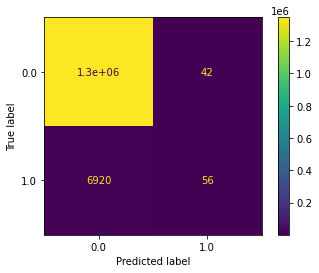

In [42]:
y_pred_lbg2  =  lbgclf2.predict(clf_features)
ConfusionMatrixDisplay.from_predictions(clf_target, y_pred_lbg2)

<span style="color:blue"> 
  The Fine  Tuning of Classifier Hyperparameters shows improvement in Confusion Matrix. The True Positive(TP) count has increased to 56. 
 
</span>    

## 7.3 LBG Regression model 

In [44]:
 gridParams_reg = {
'learning_rate': [ 0.01,0.02,0.03,0.04,0.05], #Learning rate
'n_estimators': [int(x) for x in np.linspace(start = 100, stop = 2000, num = 15)],
'num_leaves': [2,3,5,7,9,11,13,15], #number of leaves in full tree
'boosting_type' : ['gbdt' ],
'objective' : ['regression'], #Regression model to predict transaction amount
'metric' : ['rmse'], #Performance metric as "RMSE
'colsample_bytree' : [0.2,0.4,0.6,0.8,0.9, 1], #  select features before training each tree
'subsample' : [0.2,0.4,0.5,0.6,0.7,0.8,0.9, 1], #   select part of data without resampling
'reg_alpha' : [0,0.5,1], #L1 regularization
'reg_lambda' : [0,0.5,1], #L2 regularization
'max_leaves': [32,64,128,256], #Max  nodes  added.
'min_child_samples' : [1,2,3,4,5,7,10,15,20] #Min data points in child (leaf) node.
}

In [45]:
# Define LightGBM Regressor model
lbgreg = lgb.LGBMRegressor()

lbg_reg_grid = RandomizedSearchCV(estimator=lbgreg, param_distributions=gridParams_reg,
                              n_iter =10, 
                              cv = 2, verbose=10, random_state=42,  
                              return_train_score=True)

In [46]:
%%time 
lbg_reg_grid.fit(reg_features, reg_target)

Fitting 2 folds for each of 10 candidates, totalling 20 fits
[CV 1/2; 1/10] START boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.01, max_leaves=128, metric=rmse, min_child_samples=7, n_estimators=914, num_leaves=11, objective=regression, reg_alpha=1, reg_lambda=0, subsample=0.7
[LightGBM] [Warning] num_leaves is set=11, max_leaves=128 will be ignored. Current value: num_leaves=11
[CV 1/2; 1/10] END boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.01, max_leaves=128, metric=rmse, min_child_samples=7, n_estimators=914, num_leaves=11, objective=regression, reg_alpha=1, reg_lambda=0, subsample=0.7;, score=(train=0.573, test=0.082) total time=   2.0s
[CV 2/2; 1/10] START boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.01, max_leaves=128, metric=rmse, min_child_samples=7, n_estimators=914, num_leaves=11, objective=regression, reg_alpha=1, reg_lambda=0, subsample=0.7
[LightGBM] [Warning] num_leaves is set=11, max_leaves=128 will be ignored. Current value: num_lea

RandomizedSearchCV(cv=2, estimator=LGBMRegressor(),
                   param_distributions={'boosting_type': ['gbdt'],
                                        'colsample_bytree': [0.2, 0.4, 0.6, 0.8,
                                                             0.9, 1],
                                        'learning_rate': [0.01, 0.02, 0.03,
                                                          0.04, 0.05],
                                        'max_leaves': [32, 64, 128, 256],
                                        'metric': ['rmse'],
                                        'min_child_samples': [1, 2, 3, 4, 5, 7,
                                                              10, 15, 20],
                                        'n_estimators': [100, 235, 371, 507,
                                                         642, 778, 914, 1050,
                                                         1185, 1321, 1457, 1592,
                                                         1

In [47]:
lbg_reg_grid.best_params_

{'subsample': 0.7,
 'reg_lambda': 0.5,
 'reg_alpha': 0,
 'objective': 'regression',
 'num_leaves': 11,
 'n_estimators': 100,
 'min_child_samples': 3,
 'metric': 'rmse',
 'max_leaves': 256,
 'learning_rate': 0.04,
 'colsample_bytree': 0.9,
 'boosting_type': 'gbdt'}

In [48]:
lbg_reg_grid.best_score_ 

0.029840900516761193

In [49]:
lbg_regparm = {
"objective" : "regression", #Regression model to predict transaction amount
"metric" : "rmse", #Performance metric as "RMSE"
"max_leaves": 256, #Maximum number of nodes to be added.
"num_leaves" : 11, #number of leaves in full tree
"min_child_samples" : 3, #Minimum number of data points needed in a child (leaf) node.
"learning_rate" : 0.04, #Learning rate
"subsample" : 0.7, #this will randomly select part of data without resampling
"colsample_bytree" : 0.9, #LightGBM will select 80% of features before training each tree
"n_estimators" : 100, #number of boosting iterations
"reg_alpha" : 0, #L1 regularization
"reg_lambda": 0.5, #L2 regularization
'random_state': 42,    
"boosting_type" : "gbdt"}

lbgreg= lgb.LGBMRegressor(**lbg_regparm)
lbgreg.get_params() 

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 0.9,
 'importance_type': 'split',
 'learning_rate': 0.04,
 'max_depth': -1,
 'min_child_samples': 3,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 11,
 'objective': 'regression',
 'random_state': 42,
 'reg_alpha': 0,
 'reg_lambda': 0.5,
 'silent': 'warn',
 'subsample': 0.7,
 'subsample_for_bin': 200000,
 'subsample_freq': 0,
 'metric': 'rmse',
 'max_leaves': 256}

In [50]:
%%time
lbgreg.fit(reg_features, reg_target)

CPU times: user 1.27 s, sys: 15.9 ms, total: 1.29 s
Wall time: 383 ms


LGBMRegressor(colsample_bytree=0.9, learning_rate=0.04, max_leaves=256,
              metric='rmse', min_child_samples=3, num_leaves=11,
              objective='regression', random_state=42, reg_alpha=0,
              reg_lambda=0.5, subsample=0.7)

In [51]:
classifier_pred = lbgclf2.predict_proba(test.drop(target_cols,axis=1))
regressor_pred = lbgreg.predict(test.drop(target_cols,axis=1))
final_pred = (classifier_pred[:,1]*regressor_pred)

In [52]:
pred_df = pd.DataFrame({"fullVisitorId":test["fullVisitorId"].values})
pred_df["PredictedLogRevenue"] = final_pred
pred_df.columns = ["fullVisitorId", "PredictedLogRevenue"]
pred_df.to_csv("pred_lbg_models.csv", index=False)

In [53]:
regr_metric(test_df,pred_df)

rms = 2.1001401803101745
map = 0.2605983469271149


### 7.3.1  LBG Regression   Data Analysis

In [54]:
#obtain presiction value from regression
y_pred = lbgreg.predict(reg_features) 

In [ ]:
#Combine Features,target and prediction
reg_data = pd.concat([reg_features, reg_target ], axis = 1)
reg_data['reg_pred'] = y_pred
#add columns for difference between target and prediction
reg_data['y_diff'] = reg_data['reg_pred'] - reg_data['revenue']

In [55]:
reg_features.shape,reg_data.shape

((6976, 139), (6976, 142))

In [56]:
reg_data.head()

,channelGrouping_max,device.browser_max,device.operatingSystem_max,device.isMobile_max,device.deviceCategory_max,geoNetwork.continent_max,geoNetwork.subContinent_max,geoNetwork.country_max,geoNetwork.region_max,geoNetwork.metro_max,...,timeOnSite_per_dom_min,timeOnSite_per_dom_sum,timeOnSite_per_dom_mean,timeOnSite_per_dow_max,timeOnSite_per_dow_min,timeOnSite_per_dow_sum,timeOnSite_per_dow_mean,revenue,reg_pred,y_diff
612,4,35,20,False,0,4,13,217,131,60,...,2046.0,2046.0,2046.000000,3172.0,3172.0,3172.0,3172.000000,0.0,0.218244,0.218244
1334,2,35,6,False,0,2,12,218,482,122,...,2013.0,2013.0,2013.000000,3168.0,3168.0,3168.0,3168.000000,0.0,0.978402,0.978402
1454,3,72,23,True,1,4,22,75,47,0,...,2049.0,4124.0,2062.000000,3103.0,3103.0,6206.0,3103.000000,0.0,0.056382,0.056382
1995,6,35,7,False,0,2,12,218,73,100,...,2064.0,2064.0,2064.000000,3228.0,3228.0,3228.0,3228.000000,0.0,1.378282,1.378282
2179,6,35,7,False,0,2,12,218,73,100,...,2021.0,6233.0,2077.666667,3228.0,3103.0,9499.0,3166.333333,0.0,1.007588,1.007588


<AxesSubplot:>

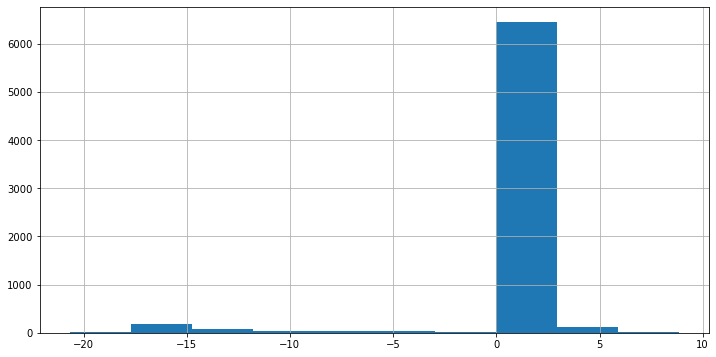

In [57]:
#plot graph of diffrence in prediction and target for regression
plt.figure(figsize=(12,6))
reg_data['y_diff'].hist()

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='y_diff', ylabel='Density'>

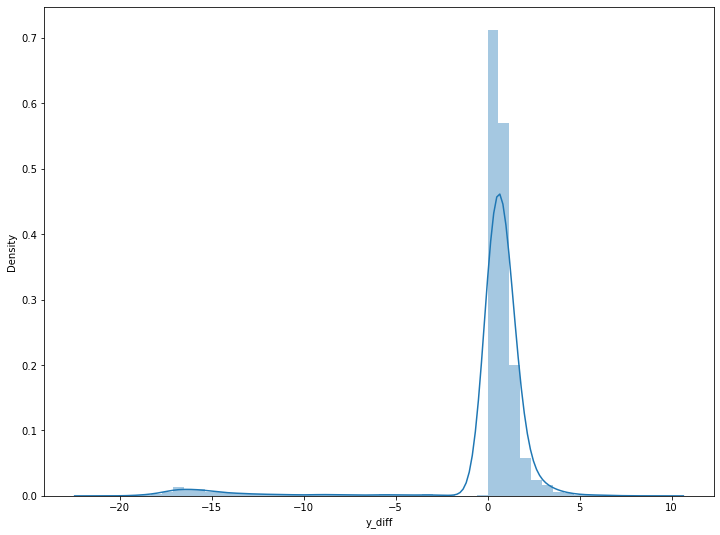

In [58]:
#plot same graph using seaborn
plt.figure(figsize=(12,9))
sns.distplot(reg_data['y_diff'])

In [59]:
#obtain quartiles of difference
reg_data['y_diff'].describe()

count    6976.000000
mean       -0.002295
std         3.511782
min       -20.648003
25%         0.193335
50%         0.656690
75%         1.036115
max         8.843963
Name: y_diff, dtype: float64

<AxesSubplot:ylabel='y_diff'>

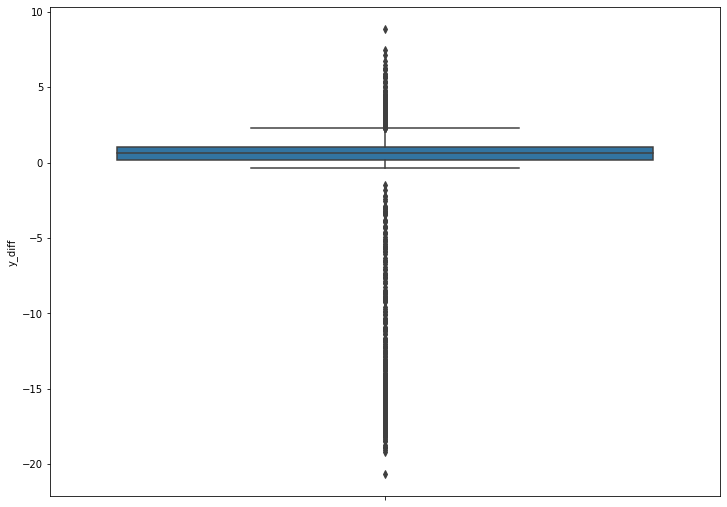

In [60]:
#plot boxplot  of difference
plt.figure(figsize=(12,9))
sns.boxplot(y = 'y_diff', data = reg_data)

### 7.3.2  LBG Regression   Data Analysis: Remove outliers

we can use the standard deviation as a cut-off for identifying outliers.
From Gaussian distribution remove  values are more than a fixed Standard Deviations from the Mean.Values outside this can be considered outliers

In [107]:
# calculate summary statistics
reg_mean = reg_data['y_diff'].mean()
reg_std  = reg_data['y_diff'].std()

reg_mean, reg_std 

(-0.002294869124223065, 3.5117817539388745)

In [121]:
# Take range of 6 sigma  
cut_off = reg_std * 6

lower = reg_mean - cut_off 
upper = reg_mean + cut_off

cut_off,lower,upper

(21.070690523633246, -21.07298539275747, 21.068395654509022)

The lower value is less than min value for difference.This means no data points are removed.

In [122]:
#remove outlier points
reg_data_std=  reg_data.loc[( reg_data['y_diff'] >= lower) & ( reg_data['y_diff'] <= upper)]

In [123]:
reg_target_std = reg_data_std['revenue']

In [124]:
reg_data_std.drop(['revenue', 'reg_pred', 'y_diff'], axis=1, inplace=True)

In [125]:
#Define LightGBM Regressor model
lbgreg_std = lgb.LGBMRegressor()

lbg_regstd_grid = RandomizedSearchCV(estimator=lbgreg_std, param_distributions=gridParams_reg,
                              n_iter =5, 
                              cv = 2, verbose=10, random_state=42,  
                              return_train_score=True)


In [126]:
%%time 
lbg_regstd_grid.fit(reg_data_std, reg_target_std)

Fitting 2 folds for each of 5 candidates, totalling 10 fits
[CV 1/2; 1/5] START boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.01, max_leaves=128, metric=rmse, min_child_samples=7, n_estimators=914, num_leaves=11, objective=regression, reg_alpha=1, reg_lambda=0, subsample=0.7
[LightGBM] [Warning] num_leaves is set=11, max_leaves=128 will be ignored. Current value: num_leaves=11
[CV 1/2; 1/5] END boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.01, max_leaves=128, metric=rmse, min_child_samples=7, n_estimators=914, num_leaves=11, objective=regression, reg_alpha=1, reg_lambda=0, subsample=0.7;, score=(train=0.573, test=0.082) total time=   1.9s
[CV 2/2; 1/5] START boosting_type=gbdt, colsample_bytree=0.9, learning_rate=0.01, max_leaves=128, metric=rmse, min_child_samples=7, n_estimators=914, num_leaves=11, objective=regression, reg_alpha=1, reg_lambda=0, subsample=0.7
[LightGBM] [Warning] num_leaves is set=11, max_leaves=128 will be ignored. Current value: num_leaves=

RandomizedSearchCV(cv=2, estimator=LGBMRegressor(), n_iter=5,
                   param_distributions={'boosting_type': ['gbdt'],
                                        'colsample_bytree': [0.2, 0.4, 0.6, 0.8,
                                                             0.9, 1],
                                        'learning_rate': [0.01, 0.02, 0.03,
                                                          0.04, 0.05],
                                        'max_leaves': [32, 64, 128, 256],
                                        'metric': ['rmse'],
                                        'min_child_samples': [1, 2, 3, 4, 5, 7,
                                                              10, 15, 20],
                                        'n_estimators': [100, 235, 371, 507,
                                                         642, 778, 914, 1050,
                                                         1185, 1321, 1457, 1592,
                                                

In [127]:
lbg_regstd_grid.best_params_

{'subsample': 0.7,
 'reg_lambda': 0,
 'reg_alpha': 1,
 'objective': 'regression',
 'num_leaves': 3,
 'n_estimators': 507,
 'min_child_samples': 4,
 'metric': 'rmse',
 'max_leaves': 256,
 'learning_rate': 0.04,
 'colsample_bytree': 0.6,
 'boosting_type': 'gbdt'}

In [128]:
lbg_regstd_grid.best_score_ 

0.02569837022942495

In [129]:
lbg_regparm_std = {
"objective" : "regression", #Regression model to predict transaction amount
"metric" : "rmse", #Performance metric as "RMSE"
"max_leaves": 256, #Maximum number of nodes to be added.
"num_leaves" : 3, #number of leaves in full tree
"min_child_samples" : 4, #Minimum number of data points needed in a child (leaf) node.
"learning_rate" : 0.04, #Learning rate
"subsample" : 0.7, #this will randomly select part of data without resampling
"colsample_bytree" : 0.6, #LightGBM will select 80% of features before training each tree
"n_estimators" : 507, #number of boosting iterations
"reg_alpha" : 1, #L1 regularization
"reg_lambda": 0, #L2 regularization
'random_state': 42,   
"boosting_type" : "gbdt"}

lbgreg_std = lgb.LGBMRegressor(**lbg_regparm_std)

In [130]:
%%time
lbgreg_std.fit(reg_data_std, reg_target_std)

CPU times: user 2.13 s, sys: 12 ms, total: 2.15 s
Wall time: 595 ms


LGBMRegressor(colsample_bytree=0.6, learning_rate=0.04, max_leaves=256,
              metric='rmse', min_child_samples=4, n_estimators=507,
              num_leaves=3, objective='regression', random_state=42,
              reg_alpha=1, reg_lambda=0, subsample=0.7)

In [131]:
classifier_pred2 = lbgclf2.predict_proba(test.drop(target_cols,axis=1))
regressor_pred2 = lbgreg_std.predict(test.drop(target_cols,axis=1))
final_pred2 = (classifier_pred2[:,1]*regressor_pred2)

In [132]:
pred_df2 = pd.DataFrame({"fullVisitorId":test["fullVisitorId"].values})
pred_df2["PredictedLogRevenue"] = final_pred2
pred_df2.columns = ["fullVisitorId", "PredictedLogRevenue"]
pred_df2.to_csv("pred_lbg_model_std.csv", index=False)

In [133]:
regr_metric(test_df,pred_df2)

rms = 2.100863174934374
map = 0.2792264059523626


### 7.3.3  LBG Regressor Feature Importance

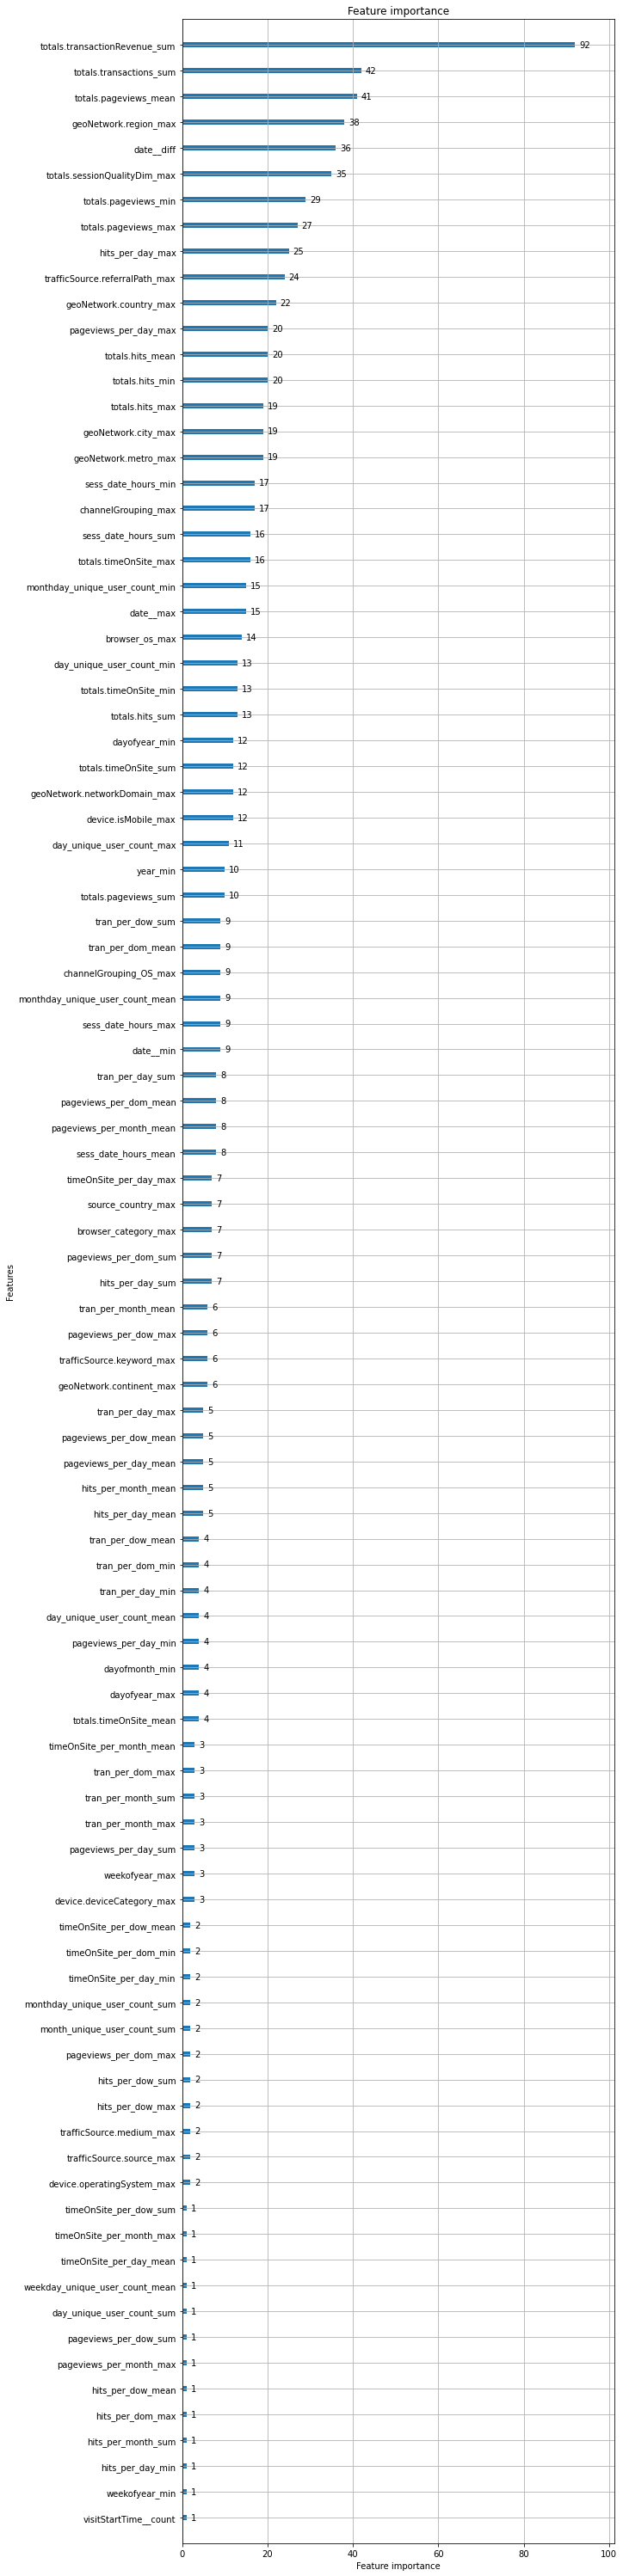

In [157]:
ax=lgb.plot_importance(lbgreg_std)
ax.figure.set_size_inches(9,54)

###  7.3.4  Model Scores

#### LightGBM (LGBMClassifier,LGBMRegressor)
rms = 2.100863174934374  
map = 0.2792264059523626   
kaggle= 0.88413 ( 16th position on leader board)  


##  7.4  Conclusion

Using cutoff of 6 sigma for outlier the kaggle score is 0.88413.    
Using cutoff of 5 sigma for outlier the kaggle score is 0.88418.    
Notebook "Google Analytics Customer Revenue Model Analysis - 5 Sigma" contains the scores when 5 sigma was 
used as cutoff.

<span style="color:blue"> 
  Since removal of data points reduces the score(using 5 sigma).We can conclude there are no outliers in data for regression model. Using 6 sigma no datapoints are removed since lower range is less than minimum value
</span>    